# Scenario 3 subtask 3: Represent Diagnosed Cases

**Background:** 10/02/2020 - 1/25/2021 in Greater Boston area. Predicting cases from wastewater potentially reports closer to the truth than testing.

**TASK:** Calibrate the modified model on 'diagnosed' cases 10/02/202 to 12/18/2020. Plot the forecast through 01/25/2021 alongside the actual 'diagnosed' 

**Specifications:**
2. Data found in supplementary materials

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyciemss.visuals.plots as plots
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model,
    load_petri_model,
    setup_petri_model,
    sample
)
from pyciemss.utils.interface_utils import convert_to_output_format
from pyciemss.utils import get_tspan

from mira.sources.askenet.petrinet import model_from_url
from mira.metamodel import Distribution
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling import Model
import urllib.request, json
import requests
from pyciemss.PetriNetODE.interfaces import (
    load_and_sample_petri_model,
    load_and_calibrate_and_sample_petri_model
)
import pyciemss.visuals.plots as plots



## Load the Viral load model with diagnosed, undiagnosed, and cumulative cases

In [2]:
S = 2300000
E = 1000
I = 0
(S+E+I)*9.06e-8

0.2084706

In [3]:

from mira.sources.askenet import model_from_json_file

template_model = model_from_json_file('ES3_detection_log10V.json')
template_model.parameters['lambda'].value = 0.208 #9.06e-8
template_model.parameters['lambda'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.2, "maximum":0.21})
template_model.parameters['gamma'].value = 0.125
template_model.parameters['beta'].value = 44852600
template_model.parameters['k'].value = 0.5
template_model.parameters['k'].distribution = Distribution(type="Uniform1", parameters={"minimum": 0.25, "maximum":0.5})

template_model

TemplateModel(templates=[ControlledConversion(rate_law=I*S*lambda/(E + I + S), name='t1', type='ControlledConversion', controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalConversion(rate_law=E*k, name='t2', type='NaturalConversion', subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalDegradation(rate_law=I*delta, name='t3', type='NaturalDegradation', su

## Uncalibrated samples

In [4]:
num_samples = 10
#timepoints = [i/10.0 for i in range(1150)]
num_samples = 100
start_time = 0
end_time = 226 # between 10/02/2020 and 01/25/2021
num_timepoints = (end_time-start_time)*10 + 1
timepoints = list(get_tspan(start_time, end_time, num_timepoints).detach().numpy())


prior_samples = load_and_sample_petri_model(template_model, num_samples, timepoints, method='dopri5',  visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")
prior_samples['data'].set_index(['timepoint_id', 'sample_id']).groupby('timepoint_id').mean()

,lambda_param,k_param,alpha_param,delta_param,beta_param,gamma_param,C_sol,D_sol,E_sol,I_sol,S_sol,U_sol,V_sol,logV_obs,timepoint_days
timepoint_id,,,,,,,,,,,,,,,
0,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,3.810861e-19,1.467042e-19,1000.000000,3.723160e-08,2.300000e+06,2.343818e-19,3.424865e+13,13.534644,0.000000
1,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,3.747010e-01,1.441897e-01,963.845175,3.630067e+01,2.300000e+06,2.305114e-01,3.427863e+13,13.535024,0.100000
2,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,1.473988e+00,5.669915e-01,929.764229,7.080965e+01,2.299999e+06,9.069965e-01,3.436659e+13,13.536136,0.200000
3,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,3.262211e+00,1.254386e+00,897.642605,1.036277e+02,2.299997e+06,2.007825e+00,3.450969e+13,13.537938,0.300000
4,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,5.705726e+00,2.193160e+00,867.371664,1.348499e+02,2.299994e+06,3.512566e+00,3.470526e+13,13.540385,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2256,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,2.299993e+06,8.563247e+05,14.212043,5.547504e+02,7.176163e+00,1.443668e+06,3.033194e+17,17.405447,225.600006
2257,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,2.299993e+06,8.563248e+05,13.963990,5.482418e+02,7.039896e+00,1.443668e+06,3.033204e+17,17.405448,225.699997
2258,0.204699,0.372316,419.921383,0.125,44852600.0,0.125,2.299993e+06,8.563249e+05,13.720092,5.418062e+02,6.906156e+00,1.443668e+06,3.033213e+17,17.405449,225.800003


## Plot the viral load data

,V
time,
0,3.424864e+13
1,7.482611e+13
2,1.107730e+14
3,1.455132e+14
4,1.789461e+14
...,...
221,1.256720e+17
222,1.257698e+17
223,1.258096e+17


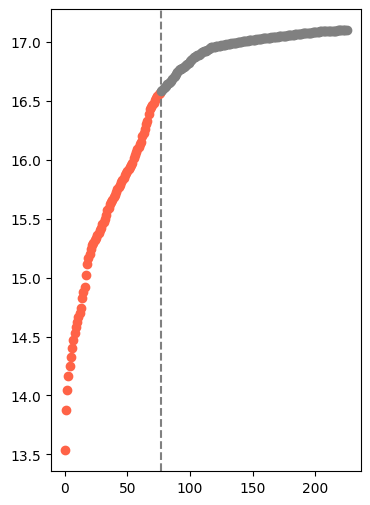

In [5]:
# Load Data
## This uses the cumsum() of the raw data
data_train = pd.read_csv('./data/processed_dataset_train.csv', index_col="time")
data_test  = pd.read_csv('./data/processed_dataset_test.csv', index_col="time")
data_whole = pd.read_csv('./data/processed_dataset.csv', index_col="time")
display(data_whole)

# Plot
plt.figure(figsize=(4,6))
plt.scatter(data_train.index, np.log10(data_train.V), color='tomato')
plt.scatter(data_test.index, np.log10(data_test.V), color='grey')
plt.axvline(77, linestyle='dashed', color='grey')

## Plot measured viral load data against uncalibrated model viral load

In [6]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"V_data"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

## Plot the diagnosed cases data

In [7]:
cases = pd.read_csv('data/datasetCumulCases.csv').dropna(how='any')
incident_cases = cases[['Time', 'cumulativecases']].rename(columns={'cumulativecases': 'reported incident cases', 'Time': 'Timestep'}).set_index('Timestep').diff().dropna()



In [8]:
measured_diagnosed_cases = pd.read_csv('data/cumulative_cases.csv')
measured_diagnosed_cases

,Timestep,D
0,0,370.0
1,1,668.0
2,2,978.0
3,3,1133.0
4,4,1332.0
...,...,...
108,111,136330.0
109,112,138392.0
110,113,140192.0
111,114,141854.0


## Plot measured diagnosed case data against uncalibrated model diagnosed cases

In [9]:
schema = plots.trajectories(pd.DataFrame(prior_samples["data"]), keep="D_sol",
                            #markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [10]:
data_train['D'] = measured_diagnosed_cases.drop('Timestep',axis=1)
data_train.reset_index().rename(columns={'time':'Timestep'}).to_csv('data/viral_load_and_diagnosed_cases.train.csv', index=False)

## Calibrate against diagnosed case data

In [11]:
calibrated_samples = load_and_calibrate_and_sample_petri_model(
            template_model,
            'data/viral_load_and_diagnosed_cases.train.csv',
            100,
            timepoints=timepoints,
            verbose=True,
            num_iterations=1000,
            visual_options={"title": "3_base", "keep":["V_sol"]}, time_unit="days")

/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=1.0000063180923462, observation={'V': tensor(7.4826e+13), 'D': tensor(668.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=2.000009775161743, observation={'V': tensor(1.1077e+14), 'D': tensor(978.)}) is not in the range [0, 34248648032256.0]. This may be an error!
  warnings.warn(f"Observation {obs} is not in the range [0, {petri.total_population}]. This may be an error!")
/Users/zuck016/Projects/Proposals/ASKEM/build/clean-build/src/pyciemss/PetriNetODE/interfaces.py:864: UserWarning: Observation ObservationEvent(time=3.000002145767212, observation={'V': tensor(1.

iteration 0: loss = 21826.96975326538
iteration 25: loss = 11353.225270748138
iteration 50: loss = 9136.754376649857
iteration 75: loss = 7378.55063533783
iteration 100: loss = 6969.085029602051
iteration 125: loss = 7030.597473859787
iteration 150: loss = 6572.877491950989
iteration 175: loss = 6245.997941970825
iteration 200: loss = 6184.317009210587
iteration 225: loss = 6124.40745139122
iteration 250: loss = 6060.840322732925
iteration 275: loss = 6030.234347343445
iteration 300: loss = 5994.801821470261
iteration 325: loss = 5864.308500528336
iteration 350: loss = 5917.95821928978
iteration 375: loss = 5836.785984516144
iteration 400: loss = 5754.945426225662
iteration 425: loss = 5746.697465181351
iteration 450: loss = 5730.49841427803
iteration 475: loss = 5712.897406578064
iteration 500: loss = 5678.019681930542
iteration 525: loss = 5699.967465877533
iteration 550: loss = 5669.717646598816
iteration 575: loss = 5636.898159265518
iteration 600: loss = 5641.318079710007
iteratio

In [15]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="D_sol",
                            markers={"Training": 77},
                            points=measured_diagnosed_cases.drop('Timestep',axis=1).rename(columns={'D': 'measured diagnosed cases'}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [16]:
schema = plots.trajectories(pd.DataFrame(calibrated_samples["data"]), keep="V_sol",
                            markers={"Training": 77},
                            points=data_whole.reset_index(drop=True).rename(columns={"V":"measured viral load"}))
schema = plots.pad(schema, 5)
plots.ipy_display(schema)

In [14]:
sorted(set(calibrated_samples['data']['k_param'].values))

[0.49409979581832886,
 0.4941830635070801,
 0.49422934651374817,
 0.4944226145744324,
 0.4944990277290344,
 0.4945080876350403,
 0.4945144057273865,
 0.49461087584495544,
 0.49464625120162964,
 0.49465373158454895,
 0.4946618378162384,
 0.494688481092453,
 0.49473121762275696,
 0.49483412504196167,
 0.4948495924472809,
 0.49486103653907776,
 0.49486762285232544,
 0.4948751628398895,
 0.4948960840702057,
 0.4949333369731903,
 0.4949474632740021,
 0.4949510097503662,
 0.4949532449245453,
 0.49495837092399597,
 0.4949612319469452,
 0.4949975609779358,
 0.4950203001499176,
 0.4950205683708191,
 0.4950730800628662,
 0.49508678913116455,
 0.4951145052909851,
 0.49512824416160583,
 0.49518123269081116,
 0.4951823949813843,
 0.49520713090896606,
 0.4952548146247864,
 0.49526217579841614,
 0.4952652156352997,
 0.4952690899372101,
 0.49527114629745483,
 0.4952719211578369,
 0.49527817964553833,
 0.49528318643569946,
 0.4952983260154724,
 0.49530547857284546,
 0.49530914425849915,
 0.495351582765